In [19]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy import units as u

from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd

import os

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from regions import RectangleSkyRegion, RegionVisual

from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())  # take environment variables from .env.

%matplotlib inline

In [2]:
filepath = os.getenv('DATAPATH')
filename = os.getenv('FILENAME')
path = os.path.join(filepath, filename)

hdu = fits.open(path)
wcs_in = WCS(hdu['SCI'].header)

$\eta$ Car's ICRS coordinates from SIMBAD:

In [3]:
etc_coords = SkyCoord('10h45m03.5377808928s -59d41m04.051599720s', frame='icrs')

Determine the optimal WCS for the image (by default the final WCS will be oriented North-Up East-Left)

In [4]:
wcs_out, shape_out = find_optimal_celestial_wcs([hdu['SCI']], reference=etc_coords)

Apply the optimal WCS transformations to the original image and save the result

In [5]:
array, footprint = reproject_and_coadd([hdu['SCI']], wcs_out, shape_out=shape_out, reproject_function=reproject_interp)

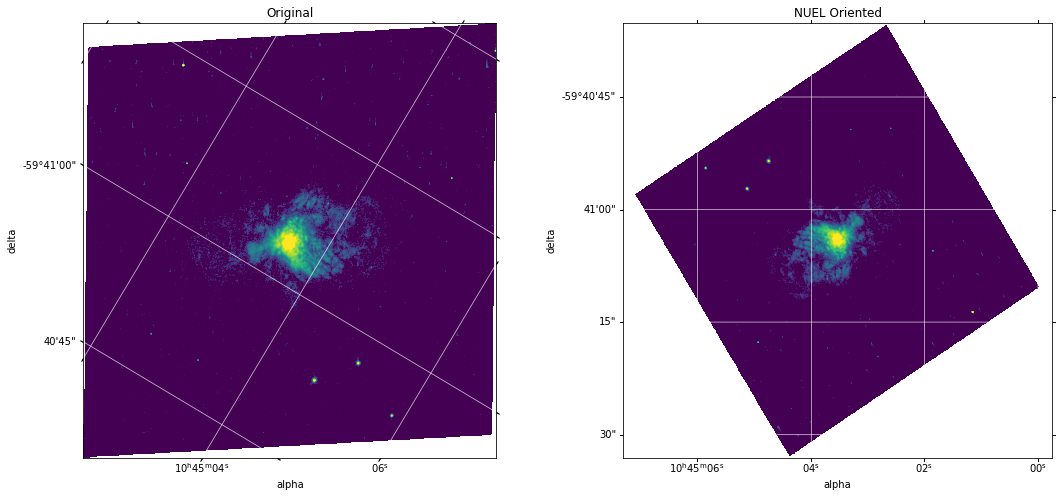

In [6]:
plt.figure(figsize=(18, 8))

vmin = 1
vmax = 100
cmap = 'viridis'
norm = colors.LogNorm(vmin, vmax, clip=True)

ax1 = plt.subplot(1, 2, 1, projection=wcs_in)
im1 = ax1.imshow(hdu['SCI'].data, origin='lower', cmap=cmap, norm=norm)
ax1.set_xlabel('alpha')
ax1.set_ylabel('delta')
ax1.set_title('Original')
ax1.grid(color='white', ls='-', alpha=0.7)

ax2 = plt.subplot(1, 2, 2, projection=wcs_out)
im2 = ax2.imshow(array, origin='lower', cmap=cmap, norm=norm)
ax2.set_xlabel('alpha')
ax2.set_ylabel('delta')
ax2.set_title('NUEL Oriented')
ax2.grid(color='white', ls='-', alpha=0.7)

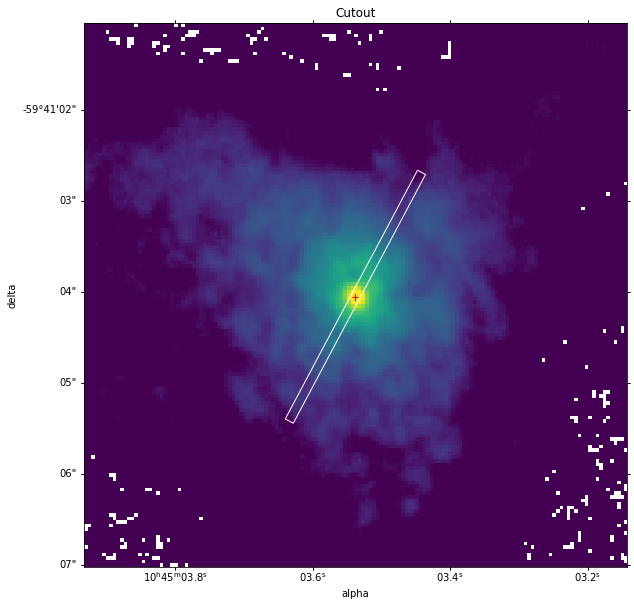

In [26]:
plt.figure(figsize=(20, 10))

# size of the cutout image (relative to the central source coordinates)
size = u.Quantity((6, 6), u.arcsec)
cutout = Cutout2D(array, etc_coords, size, wcs=wcs_out)
wcs_cutout = cutout.wcs

vmin = 10
vmax = 10000
cmap = 'viridis'
norm = colors.LogNorm(vmin, vmax)

# slit properties
slit_xc = etc_coords.ra
slit_yc = etc_coords.dec
slit_width = u.Quantity(0.1, 'arcsec')
slit_height = u.Quantity(3.1, 'arcsec')
slit_pa = u.Quantity(-28, 'deg')

ax = plt.subplot(projection=wcs_cutout)
ax.set_aspect('equal')
ax.set_xlabel('alpha')
ax.set_ylabel('delta')
ax.set_title('Cutout')
# ax.grid(color='white', ls='-', alpha=0.25)

ax.plot_coord(etc_coords, '+', color='red')

# add slit
slit = RectangleSkyRegion(
    center=etc_coords,
    width=slit_width,
    height=slit_height,
    angle=slit_pa,
    visual=RegionVisual({'edgecolor': 'white'})
)
# SkyRegion objects do not have .as_artist method so we need to convert it to a PixelRegion object first
ax.add_artist(slit.to_pixel(wcs_cutout).as_artist())

im = ax.imshow(cutout.data, origin='lower', cmap=cmap, norm=norm)